# **Abstract**

Fingerprints play a significant role in many sectors. Nowadays, fingerprints are used for identification purposes in criminal investigations. They are also used as an authentication method since they are considered more secure than passwords. Fingerprint sensors are already widely deployed in many devices, including mobile phones and smart locks. Criminals try to compromise biometric fingerprint systems by purposely altering their fingerprints or entering fake ones. Therefore, it is critical to design and develop a highly accurate fingerprint classification. However, some fingerprint datasets are small and not sufficient to train a neural network. A large Sokoto Coventry Fingerprint Dataset (SOCOFing), which contains 55,273 fingerprint images was used to create two datasets(SubjectID and Fingername), then build two convolutional neural networks and train the models with corresponding dataset. Finally, evaluate the method with a randomly picked fingerprint, when and only when both the predictions of ID and fingers name are correct then we can say the kernel works.


# **About Dataset**

Sokoto Coventry Fingerprint Dataset (SOCOFing) is a biometric fingerprint database designed for academic research purposes. SOCOFing is made up of 6,000 fingerprint images from 600 African subjects and contains unique attributes such as labels for gender, hand and finger name as well as synthetically altered versions with three different levels of alteration for obliteration, central rotation, and z-cut. For a complete formal description and usage policy please refer to the following paper: https://arxiv.org/abs/1807.10609 

In [ ]:
! pip install gdown
! gdown --id  1-H5uVGtRcK2be3ZPq1_zI6qBI9uAADYz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1-H5uVGtRcK2be3ZPq1_zI6qBI9uAADYz
To: /content/socofing.zip
100% 878M/878M [00:12<00:00, 70.3MB/s]


In [ ]:
! unzip -qq /content/socofing.zip

In [ ]:
import os
import cv2
import random
import itertools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.utils import to_categorical, plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, regularizers, optimizers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# **Preprocessing**

### Load the raw dataset, and resize the images so that they can fit CNN's input_shape.

In [ ]:
class Datalaoder(object):
  def __init__(self):
      self.img_size = 32

  def load_data(self, path, train=True):
      print("Loading data from: ", path)
      data = []
      for img in os.listdir(path):
          imgname, ext = os.path.splitext(img)
          ID, etc = imgname.split('__')
          ID = int(ID) - 1 # to_categorical encodes starting from 0
          if train:
              _, lr, finger, _, _ = etc.split('_')
          else:
              _, lr, finger, _  = etc.split('_')
          if lr=='Left':
              base = 0 # left hand corresponding to 0-4
          else: base  = 5 # right hand corresponding to 5-9
          if finger=="little":
              fingerNum = base + 0
          elif finger=='ring':
              fingerNum = base + 1
          elif finger=='middle':
              fingerNum = base + 2
          elif finger=='index':
              fingerNum = base + 3 
          else: fingerNum = base + 4
          img_array = cv2.imread(os.path.join(path, img), 1)
          img_resize = cv2.resize(img_array, (self.img_size, self.img_size))
          data.append([ID, fingerNum, img_resize])
      return data

In [ ]:
dl = Datalaoder()

In [ ]:
Altered_path = "socofing/SOCOFing/Altered/Altered-"
Real_path = "socofing/SOCOFing/Real"

Easy_data = dl.load_data(path = Altered_path+'Easy', train=True)
Medium_data = dl.load_data(path = Altered_path+'Medium', train=True)
Hard_data = dl.load_data(path = Altered_path+'Hard', train=True)
Real_data = dl.load_data(path = Real_path, train=False)

Altered_data = np.concatenate([Easy_data, Medium_data, Hard_data], axis=0)
del Easy_data, Medium_data, Hard_data # Free some memory

Loading data from:  socofing/SOCOFing/Altered/Altered-Easy
Loading data from:  socofing/SOCOFing/Altered/Altered-Medium
Loading data from:  socofing/SOCOFing/Altered/Altered-Hard
Loading data from:  socofing/SOCOFing/Real


<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


# **Split Data Into Train / Validation / Test**

### Create two datasets, SubjectID datasets and fingerNum datasets. They will be used to train two different models in the next step.

In [ ]:
X_Altered, y_SubjectID_Altered, y_fingerNum_Altered = [], [], []

for SubjectID, fingerNum, feature in Altered_data:
    X_Altered.append(feature)
    y_SubjectID_Altered.append(SubjectID)
    y_fingerNum_Altered.append(fingerNum)

X_Altered = np.array(X_Altered).reshape(-1, img_size, img_size, 3)
X_Altered = X_Altered / 255.0 # Normalize to [0, 1]
y_SubjectID_Altered = to_categorical(y_SubjectID_Altered, num_classes=600) # 600 persons in total
y_fingerNum_Altered = to_categorical(y_fingerNum_Altered, num_classes=10) # 10 fingers per person

X_SubjectID_train, X_SubjectID_val, y_SubjectID_train, y_SubjectID_val = train_test_split(
    X_Altered, y_SubjectID_Altered, test_size=0.2, random_state=2)
X_fingerNum_train, X_fingerNum_val, y_fingerNum_train, y_fingerNum_val = train_test_split(
    X_Altered, y_fingerNum_Altered, test_size=0.2, random_state=2)

In [ ]:
X_test, y_SubjectID_test, y_fingerNum_test = [], [], []

for SubjectID, fingerNum, feature in Real_data:
    X_test.append(feature)
    y_SubjectID_test.append(SubjectID)
    y_fingerNum_test.append(fingerNum)

X_test = np.array(X_test).reshape(-1, img_size, img_size, 3)
X_test = X_test / 255.0

y_SubjectID_test = to_categorical(y_SubjectID_test, num_classes=600)
y_fingerNum_test = to_categorical(y_fingerNum_test, num_classes=10)

### Output the shapes of all datasets to confirm our previous work.

In [ ]:
print("Shapes:                  Feature shape    label shape")
print("----------------------------------------------------")
print("full SubjectID data:  ", X_Altered.shape, y_SubjectID_Altered.shape)
print("SubjectID_Train:      ", X_SubjectID_train.shape, y_SubjectID_train.shape)
print("SubjectID_Validation: ", X_SubjectID_val.shape, y_SubjectID_val.shape)
print("SubjectID_Test:       ", X_test.shape, y_SubjectID_test.shape)
print("----------------------------------------------------")
print("full fingerNum data:  ", X_Altered.shape, y_fingerNum_Altered.shape)
print("fingerNum_Train:      ", X_fingerNum_train.shape, y_fingerNum_train.shape)
print("fingerNum_Validation: ", X_fingerNum_val.shape, y_fingerNum_val.shape)
print("fingerNum_Test:       ", X_test.shape, y_fingerNum_test.shape)

del Altered_data, Real_data, y_SubjectID_Altered # Free some memory again

Shapes:                  Feature shape    label shape
----------------------------------------------------
full SubjectID data:   (49270, 32, 32, 3) (49270, 600)
SubjectID_Train:       (39416, 32, 32, 3) (39416, 600)
SubjectID_Validation:  (9854, 32, 32, 3) (9854, 600)
SubjectID_Test:        (6000, 32, 32, 3) (6000, 600)
----------------------------------------------------
full fingerNum data:   (49270, 32, 32, 3) (49270, 10)
fingerNum_Train:       (39416, 32, 32, 3) (39416, 10)
fingerNum_Validation:  (9854, 32, 32, 3) (9854, 10)
fingerNum_Test:        (6000, 32, 32, 3) (6000, 10)


# **Visualization**

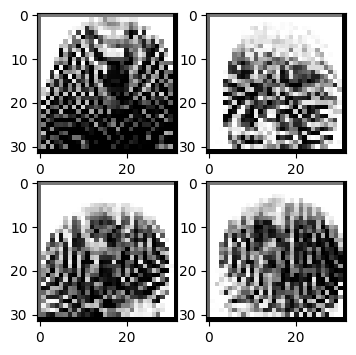

In [ ]:
import matplotlib.pyplot as plt


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,  figsize=(4, 4))
ax1.imshow(X_test[350], cmap = 'gray')
ax2.imshow(X_test[400], cmap = 'gray')
ax3.imshow(X_test[230], cmap = 'gray')
ax4.imshow(X_test[600], cmap = 'gray')


# **Model Architecture**

### Build two models(set net=2). In these models, introduce several methods to prevent overfitting, including L2 regularization, BatchNormalization, Dropout regularization, EarlyStopping and ReduceLROnPlateau.

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten

class MobileNet(object):
  def __init__(self):
    pass

  def get_model(self, calss_num):
    # load model without classifier layers
      model = MobileNetV2(include_top=False, input_shape=(32, 32, 3))
      # add new classifier layers
      flat1 = Flatten()(model.layers[-1].output)
      class1 = Dense(1024, activation='relu')(flat1)
      output = Dense(calss_num, activation='softmax')(class1)
      # define new model
      model_subject = Model(inputs=model.inputs, outputs=output)
      # summarize
      # model_subject.summary()
      return model



In [ ]:
cnn = MobileNet()

In [ ]:
model_finger = cnn.get_model(calss_num=10)

In [ ]:
model_subject = cnn.get_model(calss_num=600)

# **Visualize  models**

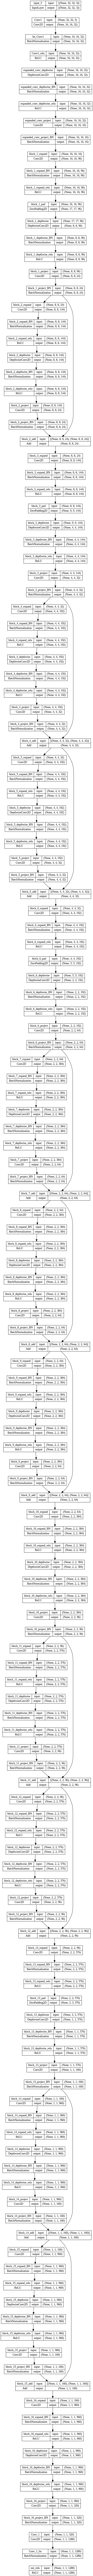

In [ ]:
#Plot Id model graph in layers
plot_model(model_finger, show_shapes=True, to_file='./model0.png')

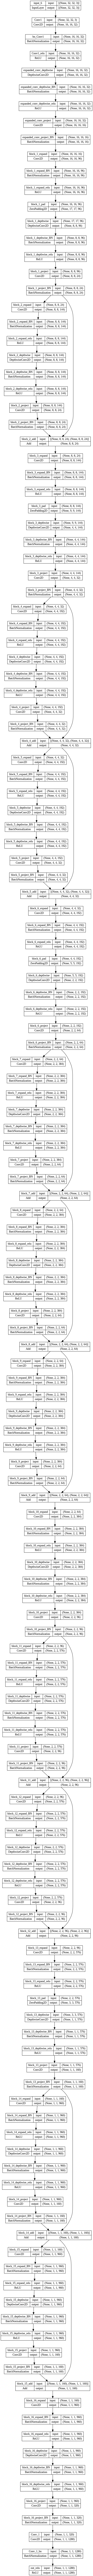

In [ ]:
# Plot finger model grapy in layers
plot_model(model_subject, show_shapes=True, to_file='./model1.png')


# **Data Augmentation**

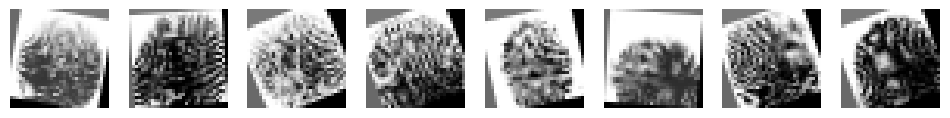

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=8, figsize=(12,12))

for i in range(8):

  # convert to unsigned integers for plotting
  image = next(datagen.flow(X_SubjectID_train, y_SubjectID_train))[0]

  image = np.squeeze(image)

  # plot raw pixel data
  ax[i].imshow(image[0])
  ax[i].axis('off')

# **Fit the models**

In [ ]:
model_subject.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

history = model_subject.fit(X_SubjectID_train, y_SubjectID_train,
                    batch_size = 32,
                    epochs = 20, 
                    validation_data = (X_SubjectID_val, y_SubjectID_val),
                    verbose = 1)

Epoch 1/20
1232/1232 [==============================] - 52s 31ms/step - loss: 6.3721 - accuracy: 0.0067 - val_loss: 6.3868 - val_accuracy: 0.0029
Epoch 2/20
1232/1232 [==============================] - 36s 29ms/step - loss: 5.4876 - accuracy: 0.0509 - val_loss: 5.8820 - val_accuracy: 0.0326
Epoch 3/20
1232/1232 [==============================] - 38s 31ms/step - loss: 4.2868 - accuracy: 0.1588 - val_loss: 4.6078 - val_accuracy: 0.1307
Epoch 4/20
1232/1232 [==============================] - 37s 30ms/step - loss: 3.0974 - accuracy: 0.3234 - val_loss: 3.0654 - val_accuracy: 0.3520
Epoch 5/20
1232/1232 [==============================] - 36s 29ms/step - loss: 2.1054 - accuracy: 0.5026 - val_loss: 1.9771 - val_accuracy: 0.5426
Epoch 6/20
1232/1232 [==============================] - 36s 29ms/step - loss: 1.4226 - accuracy: 0.6511 - val_loss: 1.1121 - val_accuracy: 0.7313
Epoch 7/20
1232/1232 [==============================] - 36s 29ms/step - loss: 0.9531 - accuracy: 0.7635 - val_loss: 0.7396 -

In [ ]:
datagen = ImageDataGenerator(rotation_range=5,  # rotation
                             horizontal_flip=True,  # horizontal flip ) 
                                   

model_subject.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

model_subject.fit(datagen.flow(X_SubjectID_train, y_SubjectID_train),
                    batch_size = 32,
                    epochs = 20, 
                    validation_data = (X_SubjectID_val, y_SubjectID_val),
                    verbose = 1)

Epoch 1/20
1232/1232 [==============================] - 114s 42ms/step - loss: 6.4483 - accuracy: 0.0033 - val_loss: 6.3953 - val_accuracy: 0.0020
Epoch 2/20
1232/1232 [==============================] - 51s 41ms/step - loss: 6.0304 - accuracy: 0.0138 - val_loss: 6.1903 - val_accuracy: 0.0119
Epoch 3/20
1232/1232 [==============================] - 51s 41ms/step - loss: 5.3991 - accuracy: 0.0401 - val_loss: 5.4053 - val_accuracy: 0.0455
Epoch 4/20
1232/1232 [==============================] - 50s 41ms/step - loss: 4.7061 - accuracy: 0.0859 - val_loss: 4.4993 - val_accuracy: 0.1046
Epoch 5/20
1232/1232 [==============================] - 50s 40ms/step - loss: 4.0185 - accuracy: 0.1532 - val_loss: 3.8151 - val_accuracy: 0.1738
Epoch 6/20
1232/1232 [==============================] - 49s 39ms/step - loss: 3.3682 - accuracy: 0.2398 - val_loss: 3.1317 - val_accuracy: 0.2750
Epoch 7/20
1232/1232 [==============================] - 52s 42ms/step - loss: 2.7455 - accuracy: 0.3375 - val_loss: 2.6056 

KeyboardInterrupt: ignored

# **Subject Detection Classification Report**

In [ ]:
import pandas as pd

# Predict the values from the test dataset
y_SubjectID_pred = model_subject.predict(X_test)
# Convert predictions classes to one hot vectors 
y_SubjectID_pred_classes = np.argmax(y_SubjectID_pred, axis=1) 
# Convert test observations to one hot vectors
y_SubjectID_real = np.argmax(y_SubjectID_test, axis=1) 
# compute the classification_report
report = classification_report(y_SubjectID_real, y_SubjectID_pred_classes, output_dict=True) 
pd.DataFrame(report).transpose()

188/188 [==============================] - 3s 10ms/step


,precision,recall,f1-score,support
0,1.000000,1.0000,1.000000,10.0000
1,1.000000,1.0000,1.000000,10.0000
2,1.000000,1.0000,1.000000,10.0000
3,1.000000,1.0000,1.000000,10.0000
4,1.000000,1.0000,1.000000,10.0000
...,...,...,...,...
598,1.000000,1.0000,1.000000,10.0000
599,1.000000,1.0000,1.000000,10.0000
accuracy,0.992500,0.9925,0.992500,0.9925
macro avg,0.993273,0.9925,0.992486,6000.0000


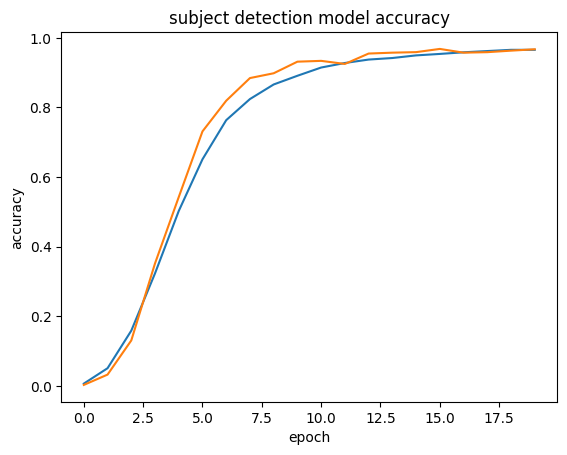

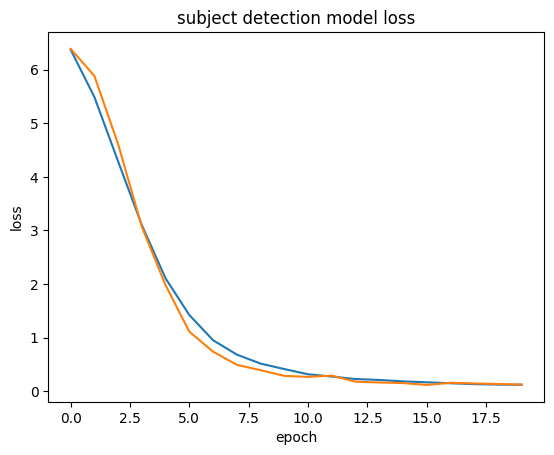

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("subject detection model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()
plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("subject detection model loss")       
plt.ylabel("loss") 
plt.xlabel("epoch")
plt.show()

In [ ]:
model_finger.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

history_finger = model_finger.fit(X_fingerNum_train, y_fingerNum_train,
                    batch_size = 32,
                    epochs = 20, 
                    validation_data = (X_fingerNum_val, y_fingerNum_val),
                    verbose = 1)

Epoch 1/20
1232/1232 [==============================] - 42s 30ms/step - loss: 2.0032 - accuracy: 0.2908 - val_loss: 2.2698 - val_accuracy: 0.1830
Epoch 2/20
1232/1232 [==============================] - 35s 29ms/step - loss: 1.6069 - accuracy: 0.4268 - val_loss: 1.9967 - val_accuracy: 0.2878
Epoch 3/20
1232/1232 [==============================] - 35s 28ms/step - loss: 1.3762 - accuracy: 0.5108 - val_loss: 1.6569 - val_accuracy: 0.4450
Epoch 4/20
1232/1232 [==============================] - 36s 29ms/step - loss: 1.1717 - accuracy: 0.5841 - val_loss: 1.3445 - val_accuracy: 0.5211
Epoch 5/20
1232/1232 [==============================] - 36s 29ms/step - loss: 0.9826 - accuracy: 0.6544 - val_loss: 1.0907 - val_accuracy: 0.6171
Epoch 6/20
1232/1232 [==============================] - 34s 28ms/step - loss: 0.8210 - accuracy: 0.7088 - val_loss: 0.7750 - val_accuracy: 0.7249
Epoch 7/20
1232/1232 [==============================] - 34s 28ms/step - loss: 0.6738 - accuracy: 0.7618 - val_loss: 0.6396 -

# **Finger Detection Classification Report**

In [ ]:
import pandas as pd
from sklearn.metrics import roc_auc_score

# Predict the values from the test dataset
y_fingerNum_pred = model_finger.predict(X_test)
# Convert predictions classes to one hot vectors 
y_fingerNum_pred_classes = np.argmax(y_fingerNum_pred, axis=1) 
# Convert test observations to one hot vectors
y_fingerNum_real = np.argmax(y_fingerNum_test, axis=1) 
# compute the classification_report
report = classification_report(y_fingerNum_real, y_fingerNum_pred_classes, output_dict=True) 
pd.DataFrame(report).transpose()



188/188 [==============================] - 2s 9ms/step


,precision,recall,f1-score,support
0,0.993056,0.953333,0.972789,600.000000
1,0.988196,0.976667,0.982397,600.000000
2,0.978297,0.976667,0.977481,600.000000
3,0.950637,0.995000,0.972313,600.000000
4,0.990099,1.000000,0.995025,600.000000
5,0.993103,0.960000,0.976271,600.000000
6,0.976744,0.980000,0.978369,600.000000
7,0.966019,0.995000,0.980296,600.000000
8,0.993289,0.986667,0.989967,600.000000
9,0.990033,0.993333,0.991681,600.000000


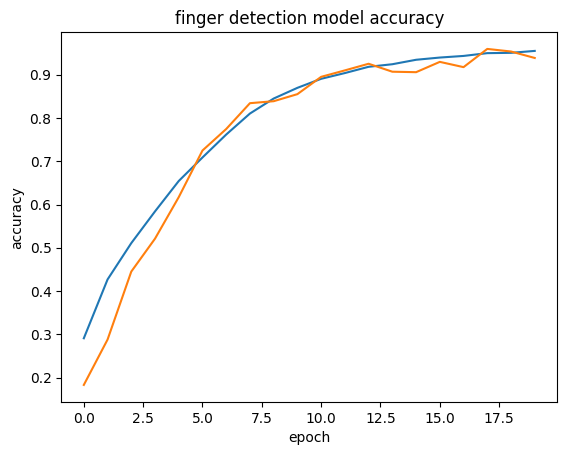

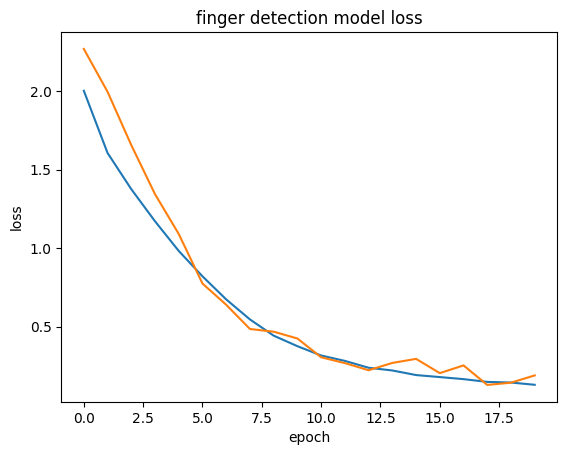

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history_finger.history["accuracy"])
plt.plot(history_finger.history["val_accuracy"])
plt.title("finger detection model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()
plt.figure()
plt.plot(history_finger.history["loss"])
plt.plot(history_finger.history["val_loss"])
plt.title("finger detection model loss")       
plt.ylabel("loss") 
plt.xlabel("epoch")
plt.show()

In [ ]:
del X_Altered, y_fingerNum_Altered


# **Learning Curves**

### Visualize the training process with accuarcy and loss, so we can adjust hyperparameters incording to these feedbacks.

# **Confusion Matrix**

### Visulize the predictions' of fingername to get a intuitional conclusion about how the model worked.

188/188 [==============================] - 1s 7ms/step


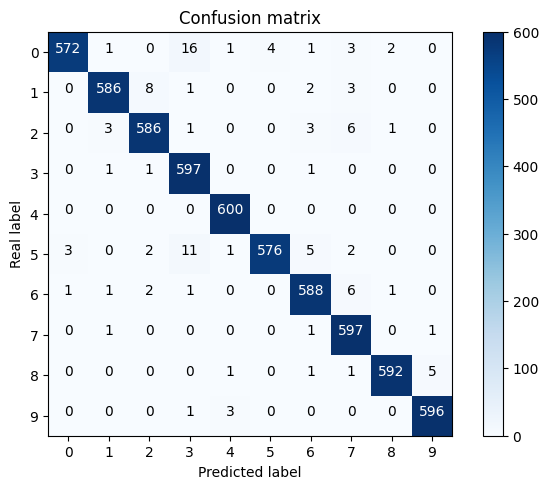

In [ ]:
# Visualize finger prediction with confusion matrix 
def plot_confusion_matrix(conmat, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(conmat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        conmat = conmat.astype('float') / conmat.sum(axis=1)[:, np.newaxis]

    thresh = conmat.max() / 2.
    for i, j in itertools.product(range(conmat.shape[0]), range(conmat.shape[1])):
        plt.text(j, i, conmat[i, j],
                 horizontalalignment="center",
                 color="white" if conmat[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Real label')
    plt.xlabel('Predicted label')

# Predict the values from the test dataset
y_fingerNum_pred = model_finger.predict(X_test)
# Convert predictions classes to one hot vectors 
y_fingerNum_pred_classes = np.argmax(y_fingerNum_pred, axis=1) 
# Convert test observations to one hot vectors
y_fingerNum_real = np.argmax(y_fingerNum_test, axis=1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_fingerNum_real, y_fingerNum_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 





# **Biometric Pipeline**

### Finally, randomly pick a fingerprint from test data to predict both its Id and fingername. When both the predictions are correct

188/188 [==============================] - 1s 8ms/step
Infomation confirm! Fingerprint matches: person Id 70 right index


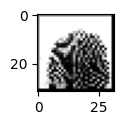

In [40]:
def show_fingername(fingernum):
    if fingernum>=5:
        fingername = "right "
        fingernum -= 5
    else: fingername = "left "
    if fingernum==0:
        fingername += "little"
    elif fingernum==1:
        fingername += "ring"
    elif fingernum==2:
        fingername += "middle"
    elif fingernum==3:
        fingername += "index"
    else: fingername += "thumb"
    return fingername

# Randomly pick a fingerprint from test data to predict both its Id and fingername
rand_fp_num = random.randint(0, X_test.shape[0]-1)
plt.figure(figsize=(1,1))
plt.imshow(X_test[rand_fp_num].reshape((32, 32, 3)), cmap ='gray')
y_SubjectID_pred = model_subject.predict(X_test)
Id_pred = np.argmax(y_SubjectID_pred[rand_fp_num])
Id_real = np.argmax(y_SubjectID_test[rand_fp_num])
fingerNum_pred = np.argmax(y_fingerNum_pred[rand_fp_num])
fingerNum_real = np.argmax(y_fingerNum_test[rand_fp_num])
if Id_pred==Id_real and fingerNum_pred==fingerNum_real:
    print("Infomation confirm! Fingerprint matches: person Id",Id_pred, show_fingername(fingerNum_pred))
else:
    print("Prediction is wrong!")